# Analyze A/B Test Results
## Project 2: Practical Statistics

## Introduction
This project covers a span of topics related to practical statistics ranging from probability and hypothesis testing to regression. Common methods used by data analysts and data scientists in the field, which cover these topics, are A/B tests.

In this project, analytical methods which leverage concepts from these topics were be applied to understanding the results of an A/B test run by an e-commerce website. The company had developed a new web page in order to increase the number of users who "convert" or decide to pay for the company's product. The analysis performed in this project aimed to provide the company with insights into whether the company should implement the new page, keep the old page, or run the experiment longer to make a decision.

## Part I - Probability
Libraries which were necessary to perform the analyses for the first part of this project were imported as shown below.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42) # use seed = 42 to reproduce the results obtained from the analyses in this project

## 1. Data Wrangling
### 1.1 General Properties
- The dataframe object df which includes the data from ab_data.csv contains five columns and 294478 rows.
- The dataset contains data for a total of 290584 unique users.
- Because the number of rows in the dataset is greater than the number of unique users, the user_id column in the dataset must - Approximately 12.1% of users converted or decided to pay for the company's product.
- 3893 rows in the dataset show incorrect assignment of group and landing_page. Either the treatment group is assigned to an old_page or the control group is assigned to a new_page.
- The dataset does not contain any null values.</l>

In [3]:
# import the dataset and display top few rows
df = pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# number of rows and columns in the dataset
df.shape

(294478, 5)

In [5]:
# number of unique users in the dataset
df.user_id.nunique()

290584

In [6]:
# proportion of users converted
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [7]:
# number of times the new_page in the landing_page and the treatment in the group do not line up
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [9]:
# number of rows with missing values
df.isna().sum(axis = 1).sum()

0

### 1.2 Data Cleaning
1.2.1 Incorrect assignment of group and landing_page
- The 3893 rows which show incorrect assignment were removed from the dataset df because the incorrect assignment renders these records inappropriate for analyzing the A/B test results.
- The updated dataset was assigned to a new object df2.
- The total number of rows decreased by 3893, from 294478 to 290585.
- The new dataframe object df2 does not contain any rows with incorrectly assigned group and landing_page.

In [10]:
# updated dataframe with correctly assigned group and landing_page
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)
df2.shape

(290585, 5)

In [11]:
# validate removal of rows with inaccurate assignment of group and landing_page
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

1.2.2 Duplicate value in user_id column in the new dataframe object df2
- A single user is duplicated once because there is one more total number of rows than the number of unique users.
- Because the two rows with this duplicate user_id of 773192 contain identical data across columns, the second row was removed from df2.
- After the dataframe df2 was updated, the total number of rows became equal to the total number of unique users.

In [12]:
# number of unique users in the updated dataframe
df2.user_id.nunique()

290584

In [13]:
# duplicate user_id
user = {}
for userid in df2.user_id:
    if userid not in user:
        user[userid] = 1
    else: # more than one instance of a user_id
        user[userid] += 1
        duplicate_user_id = userid
        print(duplicate_user_id)

773192


In [14]:
# rows containing duplicate user_id
df2.query('user_id == @duplicate_user_id')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# remove duplicate from df2
ind = df2.query('user_id == @duplicate_user_id').index[1] # second of the two rows containing duplicate user_id
df2.drop(labels = ind, inplace = True)
df2.reset_index(inplace = True, drop = True)

In [16]:
# dimensions of updated dataframe
df2.shape

(290584, 5)

### 2. Exploratory Data Analysis

The probability of the users in the control group to convert was approximately 0.2% larger than the probability of the users in the treatment group to convert. Because the proportion of each group was nearly the same, the difference in the probability may appear to suggest that the old_page is still more effective than the new_page in converting the users.

However, in terms of implementing a new page or keeping the current one, 0.2% difference in the probability may not hold any practical significance. In fact, the statistical significance of this difference remains uncertain given the 12.0% probability of users converting regardless of the group the user is in.

In [17]:
# probability of a user converting regardless of the user's group
(df2['converted'] == 1).mean()

0.11959708724499628

In [18]:
# probability of a user in the control group converting
obs_p_old = (df2.query('group == "control"')['converted'] == 1).mean()
obs_p_old

0.1203863045004612

In [19]:
# probability of a user in the treatment group converting
obs_p_new = (df2.query('group == "treatment"')['converted'] == 1).mean()
obs_p_new

0.11880806551510564

In [20]:
# probability of a user receiving a new page
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

## Part II - A/B Test
Given the time stamp recorded for each user's transaction, the hypothesis test can be performed continuously as each observation is observed. However, the following questions posed challenges to this approach.

Should the test stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?
How long should the test be run to render a decision that neither page is better than another?
For simplicity, time factor was excluded from the scope of the analysis.

1. Hypotheses
A/B test was performed under the assumption that the old page yields a larger convert rate than the new page unless the new page proves to definitely yield a larger convert rate at a Type I error rate of 5%. Based on this assumption,

for the Null Hypothesis, the probability of all users who convert from landing on the old page is greater than or equal to the probability of all users who convert from landing on the new page.
for the Alternative Hypothesis, the probability of all users who convert from landing on the new page is greater than or equal to the probability of all users who convert from landing on the old page.

$$H_0: p_{new} - p_{old} \leq 0$$$$H_1: p_{new} - p_{old} &gt; 0$$

### 2. Sampling Distribution of Differences in Convert Rates
Under the null hypothesis, assume that the two probabilities $p_{new}$ and $p_{old}$ are equal to the convert rate observed in ab_data.csv regardless of the page. To note that these probabilities are based on the null hypothesis, null_ was added to the names of the objects as shown below.

In [21]:
# convert rates for each group under the null
null_p_new = (df2['converted'] == 1).mean() # control
null_p_old = null_p_new # treatment
null_p_new

0.11959708724499628

To simulate outcomes (convert value of 0 or 1) from the null hypothesis for each page, the sample size for each page equal to the sizes of each page in ab_data.csv was used.

In [22]:
# sample size of the new page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

In [23]:
# sample size of the old page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

For each of the two groups, one with new_page and another with old_page, outcomes of conversion indicated by 1's for converted and 0's for not converted were simulated and stored in the objects new_page_converted and old_page_converted.

In [24]:
# simulation of n_new outcomes with a convert rate of null_p_new
new_page_converted = np.random.binomial(n = 1, p = null_p_new, size = n_new)

In [25]:
# simulation of n_old outcomes with a convert rate of null_p_old
old_page_converted = np.random.binomial(n = 1, p = null_p_old, size = n_old)

From this simulation, the difference in the convert rates between the two groups was approximately 0.02%.

In [26]:
# simulation of difference in covert rates between groups
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.00023196601259739547

This simulation of calculating an estimate from the null was conducted 10000 times to perform the sampling distribution for the difference in the convert rates between the two pages. The sampling distribution of the 10000 differences was stored in p_diffs.

In [28]:
# sampling distribution of 10000 differences in convert rates between groups
p_diffs = []

new_converted_sim = np.random.binomial(n = n_new, p = null_p_new, size = 10000)/n_new # 10000 convert rates of control group
old_converted_sim = np.random.binomial(n = n_old, p = null_p_old, size = 10000)/n_old # 10000 convert rates of treatment group
p_diffs.append(new_converted_sim - old_converted_sim) # 10000 differences in convert rates between groups

Given the sufficiently large size of the sample and the fact that the difference in the convert rates is a random variable, the distribution of the differences should be approximately normal according to the Central Limit Theorem. The histogram of the differences estimated from the null hypothesis confirms this expectation. The normal distribution is centered at 0 with a standard deviation of 0.0012.

In [29]:
# mean and standard deviation of the sampling distribution
p_diffs_mean = np.array(p_diffs).mean()
p_diffs_std = np.array(p_diffs).std()
p_diffs_mean, p_diffs_std

(1.301915870599088e-06, 0.0012091679452238002)

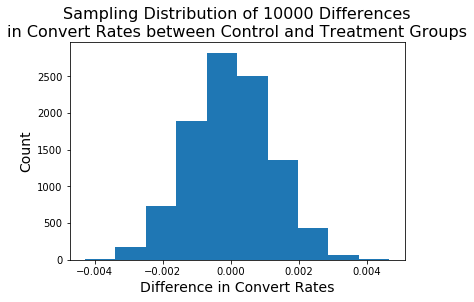

In [30]:
# histogram of 10000 differences in convert rates between groups
plt.hist(x = p_diffs)
plt.title('Sampling Distribution of 10000 Differences\nin Convert Rates between Control and Treatment Groups', fontsize = 16)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Difference in Convert Rates', fontsize = 14);

### 3. p-Value
The value of obs_p_diff or the difference in the two convert rates observed in ab_test.csv is 0.158%, showing higher convert rate for the old page. According to the visualization below, the proportion of values in p_diffs which are larger than the observed statistic and thus are considered extreme was 90.7%, which exceeds the tolerance level of 5%.

This significantly large p-value also illustrated by the relatively large portion of the histogram to the right of the red vertical line suggested a large probability in rejecting the null hypothesis when the null hypothesis is in fact true. Therefore, based on this p-value, the null hypothesis could not be rejected. The convert rate of all users in the old page was found to be equal to or larger than that of all users in the new page.

In [31]:
# observed difference in convert rates between groups
obs_p_diff = obs_p_new - obs_p_old
obs_p_diff

-0.0015782389853555567

In [32]:
# p-value: proportion of sampled differences larger than the observed difference
p_val = (p_diffs > obs_p_diff).mean()
p_val

0.905

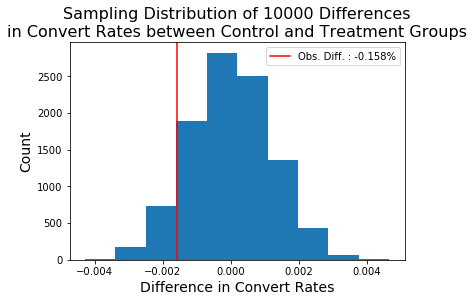

In [33]:
# histogram of 10000 differences in convert rates between groups
plt.hist(x = p_diffs)
plt.axvline(x = obs_p_diff, color = 'r', label = 'Obs. Diff. : {}%'.format(round(obs_p_diff*100, 3)))
plt.title('Sampling Distribution of 10000 Differences\nin Convert Rates between Control and Treatment Groups', fontsize = 16)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Difference in Convert Rates', fontsize = 14)
plt.legend();

### 4. Two-sample Z-test
In an attempt to reproduce the results from the previous analysis, a two-sample Z-test was performed with the method statsmodels.stats.proportion.proportions_ztest(), the documentation for which is available here. This method requires for each of the two samples, the size of the sample or the number of users who received each page and the number of successes or the number of conversions for each page.

- The size of each sample was computed earlier in Sampling Distribution of Differences in Convert Rates. n_old and n_new refer to the number of rows associated with the old page and new pages, respectively.
- The number of conversions for the old page and the new page are computed below and stored in convert_old and convert_n

In [34]:
from statsmodels.stats import proportion

# number of conversions for each page
convert_old = (df2.query('landing_page == "old_page"')['converted'] == 1).sum() # old page
convert_new = (df2.query('landing_page == "new_page"')['converted'] == 1).sum() # new page

Because the alternative hypothesis was defined as $p_{new} - p_{old} &gt; 0$, the first elements specified in the count and nobs arguments correspond to the users with the new page whereas the second elements in these two arguments correspond to the users with the old page.

In [36]:
# z-score and p-value from z-test
zscore, pval = proportion.proportions_ztest(count = [convert_new, convert_old] # number of conversions
                                            , nobs = [n_new, n_old] # number of users in each page
                                            , alternative = 'larger')
zscore, pval

(-1.3109241984234394, 0.9050583127590245)

In [37]:
# z-score and p-value from sampling distribution
z_score = (obs_p_diff - p_diffs_mean) / p_diffs_std
z_score, p_val

(-1.3063039815646162, 0.905)

The p-value obtained from the two-sample Z-test and the p-value obtained from the sampling distribution were both approximately 90%. Also, the z-score obtained from the Z-test and the z-score obtained from the sampling distribution were both approximately -1.3. Findings from both approaches indicated that the observed statistic was 1.3 standard deviation below the mean and suggest that the null hypothesis could not be rejected: the conversion rate of the old page must be equal to or larger than the conversion rate of the new page.

## Part III - Regression Approach
### 1. Conversion vs. Landing Page
Because the analysis deals with a binary outcome, whether or not the landing_page resulted in a conversion, a logistic regression was also used to analyze the A/B test results. To begin performing this regression, a new column for the intercept was added to the dataframe df2.

In [38]:
# add intercept column
df2['intercept'] = 1
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1


For the categorical variable landing_page which will serve as a predictor variable along with the intercept column to predict conversions, a dummy variable called ab_page was created. Values 0 and 1 encode the old page and the new page, respectively. This dummy variable was added to the dataframe df2 to create a new dataframe df3 for this logistic regression.

In [39]:
# create dummy variable for the landing page
dummy = pd.get_dummies(data = df2['landing_page'])['new_page'] # column with 1 for new page and 0 for old page

In [40]:
# add the dummy column to df2 and create a new dataframe
df3 = df2.join(dummy)
df3.rename(columns = {'new_page':'ab_page'}, inplace = True)
df3.head(4)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1


With the statsmodels, the model was instantiated and fit with the two columns intercept and ab_page to predict the value for converted. The summary of this logistic regression is shown and discussed below.


In [41]:
# logistic regression for conversion vs. page
import statsmodels.api as sm

log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:06:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Here, the p-value associated with ab_page is different from the p-values previously obtained from the sampling distribution and the two-sample Z-test because of the discrepancy in the null hypothesis between the linear regression and the other two approaches from Part II. This regression aims to provide estimates for the two constants, $\beta_0$ and $\beta_1$, in the model shown below in which $p_i$ and $ab\_page_i$ denote the convert rate and the landing page for the $i$-th observation, respectively.$$log\frac{p_i}{1-p_i} = \beta_0 + \beta_1 * ab\_page_i$$Based on this model, the null hypothesis for the logistic regression is that whether a conversion occurs is independent of the landing page and can be quantitatively expressed as the following.$$\beta_1 = 0$$Although the p-value associated with ab_page is relatively small, this null hypothesis could not be rejected because this p-value of 19% is larger than the tolerance level of 5%. In fact, the coefficient associated with ab_page indicates that holding all other variables constant, the convert rate for the old page is approximately 1.02 times the convert rate for the new page. In other words, the results from the logistic regression and those from the sampling distribution and the two-sample Z-test all indicate that the company should not implement the new page but keep the current one.

In [42]:
# multiplicative increase in convert rate for old page
beta1 = -0.0150
1/np.exp(beta1)

1.015113064615719

This recommendation for the company can also be verified by converting the p-values between two-tail and one-tail tests.

- In case of the two-tail test, the proportion of extreme values below the expected values from the null is half the p-value from the logistic regression or 0.190/2=0.095.
- In case of the one-tail test, the proportion of extreme values that were larger than the observed statistic was approximately 91% according to the p-value obatined from sampling values from the null hypothesis.

The p-value from the two-tail test can be converted to the p-value from the one-tail test by excluding the proportion of extreme values below the expected values from the null, 1−0.095 = 0.905, which is approximately 91%. Again, because the p-value from either tests is larger than the tolerance level of 5%, the null hypothesis could not be rejected.

In addition to the landing page, there may be other factors which influence whether or not an individual converts. Adding these additional factors to the model may be beneficial in that the model may not only be fit more accurately but be generalized to predict outcomes from a new dataset. A potential disadvantage accompanied by this addition is the possibility of any correlation among the predictor variables added to the model to predict the outcome. In such case, interactive terms for the predictor variables which are dependent of each other need to be added, resulting in a more complex model which renders analysis of estimates less intuitive or more challenging.



## 2. Conversion vs. Landing Page and Country
To explore the impact of the country where the user lives on the convert rate, data available in countries.csv was added to the previous dataframe df3. No cleaning of the resulting dataframe df_new was necessary besides resetting the index to perform the join() because countries.csv and df3 not only have the same number of rows but have the same number of unique users.

In [43]:
# countries dataset
countries_df = pd.read_csv('data/countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# number of rows in countries_df and df3 is the same
countries_df.shape[0] == df3.shape[0]

True

In [45]:
# number of unique users in countries_df and df3 is the same
countries_df.user_id.nunique() == df3.user_id.nunique()

True

In [46]:
# join countries_df and df3
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner').reset_index()
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


To include country to the logistic regression, a dummy variable was added to df_new for each unique value of country. US was selected as the baseline among the three dummy variables.

In [47]:
# unique values for country
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [48]:
# create dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


As shown below in the summary of the logistic regression, the pseudo R-squared increased by an order of magnitude with the addition of country to the predictor variables. This change suggests an increase in the capability of this new model to predict the conversion from the predictor variables. Also, the coefficients associated with the three countries show that holding all other variables constant, convert rate increases in the order of CA, US, and UK.

In [49]:
# logistic regression for conversion vs. page, country
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:               2.323e-05
Time:                        15:10:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [50]:
1/(np.exp(-0.0408)), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

## 3. Interaction Terms
To explore the impact of the interaction between page and country on the conversion, two new columns ab_page_CA and ab_page_UK, which represent the interaction terms, were added to df_new.

In [51]:
# add interaction terms to the dataframe
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_page_CA,ab_page_UK
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


With the addition of the two interaction terms, the pseudo R-square increased from the previous model. However, the magnitude of the increase is less than the increase which resulted from the addition of the country to the predictor variables. In other words, the capability of the model to predict conversion increased with the addition of the two interaction terms but not to a degree that was accomplished by the addition of the country to the logistic regression model.

In [52]:
# logistic regression for conversion vs. page, country, including interaction terms
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:               3.482e-05
Time:                        15:11:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

# Conclusions
In this project, sampling distribution, two-sample Z-test, and logistic regressions were used to analyze the A/B tests conducted by the e-commerce company.

The relatively small p-values obtained from both the sampling distribution of the differences in the convert rates between the treatment and the control groups and the two-sample Z-test did not provide enough evidence for rejecting the null hypothesis. In other words, according to the A/B tests, the company was not recommended to implement the new page because the convert rate for the old page was determined to be equal to or larger than the convert rate for the new page. Additional data concerned with the context in which the timestamp of each transaction was recorded or the interpretation of these timestamps would introduce potential improvements to the A/B testing in that outcomes of transactions can be monitored continuously. Findings from a more comprehensive analysis would provide the company with insights into the optimal duration of the A/B testing before the company makes a decision on implementing the new page or keeping the old page.

The logistic regressions did not provide similar p-values as the sampling distribution and the two-sample Z-test because the null and the alternative hypotheses for the logistic regressions were concerned with whether the outcome can be predicted with certain predictor variables. However, conversion of the p-value from the two-tail test to the one-tail test showed that the findings from the logistic regression also supported the null hypothesis. The first model aimed to predict the conversion with the landing page. The second model added country where the users live to the predictor variables of the first model. The third model included interaction terms among the predictor variables from the second model. From the first to the second and the third models, increase in the pseudo R-square suggested an increase in the capability of the model to account for the observed outcome and predict conversion.